<a href="https://colab.research.google.com/github/liman8/Notebooks/blob/main/Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maze Solver

A **maze** is a rectangular array of cells. The **agent** may move across the cells of the mase. By stepping into a cell, the agent receives a reward (or pays a penalty). Some cells are **terminal**, when stepping into a terminal cell the agent finishes the game (exits the maze). The **goal** of the agent is to maximize the total cummulative reward (minimize the total cummulative loss).

In addition to **regular** and **terminal** cells, there are also **walls**: walls are forbidden areas of the maze. The agent canot step onto a wall cell.

<div class="alert alert-block alert-info">
<b>The Assignment:</b>
Implement the maze environment and develop optimal decision policy for moving across the maze.
</div>

## Basic Imports

In [ ]:
from abc import ABC, abstractmethod
from typing import Iterable, Callable
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from random import random, choices

## The Maze

Let us implement the maze first, so that later we can implement solution algorithm(s).

We will start by implementing individual cells, and the we will collect them all within a single maze board.

### Implementing Individual Cells

In [ ]:
class Cell(ABC):
    """Abstract base class for all maze cells."""

    @abstractmethod
    def get_reward(self) -> float:
        """The reward an agent receives when stepping onto this cell."""
        pass

    def is_steppable(self) -> bool:
        """Checks if an agent can step onto this cell.

        Regular and terminal cells are steppable.
        Walls are not steppable.
        """
        return True

    def is_terminal(self) -> bool:
        """Checks if the cell is terminal.

        When stepping onto a terminal cell the agent exits
        the maze and finishes the game.
        """
        return False

    def has_value(self) -> bool:
        """Check if the cell has value.

        The value is defined for regular cells and terminal cells,
        but not for walls.
        """
        return True

We will use the `Cell` class to derive all other cell classes. Please note that it may seem that `is_steppable` and `has_value` are essentially synonims, but this is not true in general.

Consider for example **teleport cells**. When stepping onto such a cell the agent is instantinuously transported into another, linked cell. Such a cell is different from the cell to which it is linked. It has a distinct geometrical location, and is steppable. However, from routing point of view it is just an alias for the linked cell, and so there is no reason for it to have a distinct value.

Let us now implement some basic types of cells:

In [ ]:
class RegularCell(Cell):
    """A common, non-terminal, steppable cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward


class TerminalCell(Cell):
    """A terminal cell."""

    def __init__(self, reward: float):
        self.reward = reward

    def get_reward(self) -> float:
        return self.reward

    def is_terminal(self) -> bool:
        return True

    def has_value(self) -> bool:
        return False


class WallCell(Cell):
    """A non-steppable cell."""

    def get_reward(self) -> float:
        return 0

    def is_steppable(self) -> bool:
        return False

    def has_value(self) -> bool:
        return False

### Implementing the Maze Board

The maze board is essentially a rectangular grid of cells. The board is not concerned with the type of individual cells, it is only interested in their relative arrangement.

In [ ]:
class MazeBoard:
    """Rectangular grid of cells representing a single mase."""

    @staticmethod
    def validate_cells(cells: Iterable[Iterable[Cell]]) -> tuple[int, int, list[list[Cell]]]:
        """
        Utility function used to validate the given double-iterable of of cells.

        Returns: tuple[int, int, list[list[Cell]]]
            int: number of rows
            int: number of columns
            list[list[Cell]]: double-list of cells from the input iterable
        """
        cells = [list(row) for row in cells] if cells else []
        if not cells:
            raise Exception("Number of rows in a board must be at least one.")
        if not cells[0]:
            raise Exception("There has to be at least one column.")
        rows_no = len(cells)
        cols_no = len(cells[0])
        for row in cells:
            if not row or len(row) != cols_no:
                raise Exception(
                    "Each row in a a board must have the same number of columns. ")
        return rows_no, cols_no, cells

    def __init__(self, cells: Iterable[Iterable[Cell]]):
        """
        Initialize the maze board from the given `cells`.

        The input double-iterable of cells is such that the elements of the outer
        iterable are considered to be rows. The input cells must satisfy certain
        conditions in order to be considered valid:

        * There must be at least one row.
        * All rows must be of the same length, which is at least one.
        """
        rows_no, cols_no, cells = MazeBoard.validate_cells(cells)
        self.cells = cells
        self.rows_no = rows_no
        self.cols_no = cols_no

    def __getitem__(self, key: tuple[int, int]) -> Cell:
        """Return cell in the given row and column."""
        r, c = key
        return self.cells[r][c]


### Creating and Visualizing Maze Boards

It would be nice to be able to randomly generate maze boards, and also to visualize them. It will enable us to effectively test our algorithms.

Let us first create a method for randomly generating boards. We will define this method to be very generic, allowing for different kind of cells to be generated with different probability.

In [ ]:
# Type-hint used to indicate a function which, when invoked, generates a cell.
CellGenerator = Callable[[], Cell]

def create_random_board(size: tuple[int, int], specs=list[tuple[float, CellGenerator]]) -> MazeBoard:
    """
    Generate a random cell.

    Args:
        size (float): Board size: height and width.
        specs (list[tuple[float, CellGenerator]]):
            List of tuples, each of which contains a weight factor and a Cell-generating function
            The weight-factor is proportional to the probability with thich the Cell-generator
            function will be invoked.
    """
    h, w = size
    weights = [w for w, _ in specs]
    generators = [g for _, g in specs]
    # The line below is a bit tricky...
    # `random_cell` is a function which returns a random cell once it has been invoked.
    # `choices` function returns a list of elements taken from `generators` with probabilities
    #    proportional to `weights`. The length of such list is set to 1. Therefore by indexing
    #    with `[0]` we are actually requiesting for the first and only element of that list.
    # In this way we obtained one such randomly selected generator.
    # We need to invoke it with `()` in order to actually get a cell.
    random_cell = lambda: choices(generators, weights, k=1)[0]()
    cells = [[random_cell() for i in range(w)] for j in range(h)]
    return MazeBoard(cells)

Let us furhter define a function that will help us visualize maze boards.

In [ ]:
def default_cell_color(cell: Cell) -> tuple[int, int, int]:
    if isinstance(cell, RegularCell):
        if cell.get_reward() == -1:
            return (255, 255, 255) # Regular cell
        else:
            return (255, 0, 0) # Regular cell with penalty
    elif isinstance(cell, WallCell):
        return (0, 0, 0) # Wall cell
    else:
        return (0, 0, 255) # Terminal cell

def draw_board(board: MazeBoard, color = default_cell_color, pos: tuple[int, int] = None, ax=None):
    ax = ax if ax is not None else plt
    board_img = np.ones(shape=(board.rows_no, board.cols_no, 3), dtype=np.uint8)
    for i in range(board.rows_no):
        for j in range(board.cols_no):
            board_img[i, j, :] = color(board[i, j])
    if pos is not None:
        row, col = pos
        ax.text(col-0.1, row+0.1, "X", fontweight="bold")
    if ax is not None:
        ax.imshow(board_img)
    else:
        plt.imshow(board_img)

### Testing Maze Board Generation and Visualization

In [ ]:
# This will be used as the default specification for the generator...
# It requires that the reqular cells with reward -1 are 7 times more likely than
# regular cells with higher penalty, walls and terminal cells.

DEFAULT_SPECS = [
    (10, lambda: RegularCell(-1)),
    (2, lambda: RegularCell(-10)),
    (2, lambda: WallCell()),
    (1, lambda: TerminalCell(-1))
]

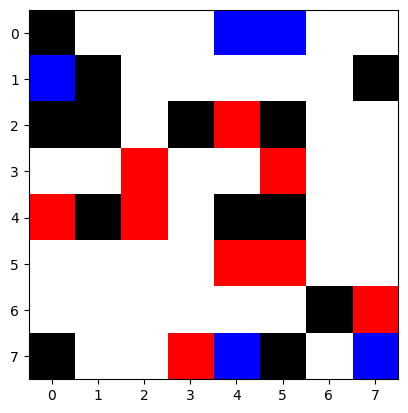

In [ ]:
board = create_random_board(size=(8, 8), specs=DEFAULT_SPECS)
draw_board(board);

### Maze as an MDP Environment

We will now wrap the maze board within a MDP environment which we will be used within our Dynamic Programming procedure.

In [ ]:
# Let us first enumerate the possible actions for better readability.
RIGHT = 0
UP = 1
LEFT = 2
DOWN = 3

# The following lus is used only to provide human-readable form of each action
ACTIONS = ["RIGHT", "UP", "LEFT", "DOWN"]

In [ ]:
class MazeEnvironment:
    """Wrapper for a maze board that behaves like an MDP environment.

    This is a callable object that behaves like a deterministic MDP state
    transition function: given the current state and action, it returns the
    following state and reward.

    In addition, the environment object is capable of enumerating all possible
    states and all possible actions. For a given state it is also capable of
    deciding if the state is terminal or not.
    """

    def __init__(self, board: MazeBoard):
        """Initialize the enviornment by specifying the underlying maze board."""
        self.board = board

    def validate_position(self, row, col):
        """A utility function that validates a position."""
        if row < 0 or row >= self.rows_no:
            raise Exception("Invalid row position.")
        if col < 0 or col >= self.cols_no:
            raise Exception("Invalid column position.")
        if not self.board[row, col].is_steppable():
            raise Exception("Invalid position: unsteppable cell.")
        return r, c

    def move_up_from(self, row: int, col: int) -> tuple[int, int]:
        if row != 0 and self.board[row-1, col].is_steppable():
            return row-1, col
        else:
            return row, col

    def move_down_from(self, row: int, col: int) -> tuple[int, int]:
        if row != self.board.rows_no-1 and self.board[row+1, col].is_steppable():
            return row+1, col
        else:
            return row, col

    def move_left_from(self, row: int, col: int) -> tuple[int, int]:
        if col != 0 and self.board[row, col-1].is_steppable():
            return row, col-1
        else:
            return row, col

    def move_right_from(self, row: int, col: int) -> tuple[int, int]:
        if col != self.board.cols_no-1 and self.board[row, col+1].is_steppable():
            return row, col+1
        else:
            return row, col

    def move_from(self, row: int, col: int, action: int) -> tuple[int, int]:
        if action == RIGHT:
            return self.move_right_from(row, col)
        elif action == UP:
            return self.move_up_from(row, col)
        elif action == LEFT:
            return self.move_left_from(row, col)
        elif action == DOWN:
            return self.move_down_from(row, col)
        else:
            raise Exception("Invalid direction.")

    def __call__(self, state: tuple[int, int], action: int) -> tuple[tuple[int, int], float, bool]:
        row, col = state
        new_row, new_col = self.move_from(row, col, action)
        new_cell = self.board[new_row, new_col]
        reward = new_cell.get_reward()
        is_terminal = new_cell.is_terminal()
        return (new_row, new_col), reward, is_terminal

    def get_states(self):
        states = []
        for r in range(self.board.rows_no):
            for c in range(self.board.cols_no):
                if self.board[r, c].is_steppable():
                    states.append((r, c))
        return states

    def is_terminal(self, s):
        return self.board[s[0], s[1]].is_terminal()

    def get_actions(self):
        return [RIGHT, UP, LEFT, DOWN]

Let us test the MDP environment. This will also enable us to understand better the manner in which the environment object is intended to be used.

### Testing the Maze Environment

Let us test the environment by issuing several commands and observing the result.

In [ ]:
env = MazeEnvironment(board)

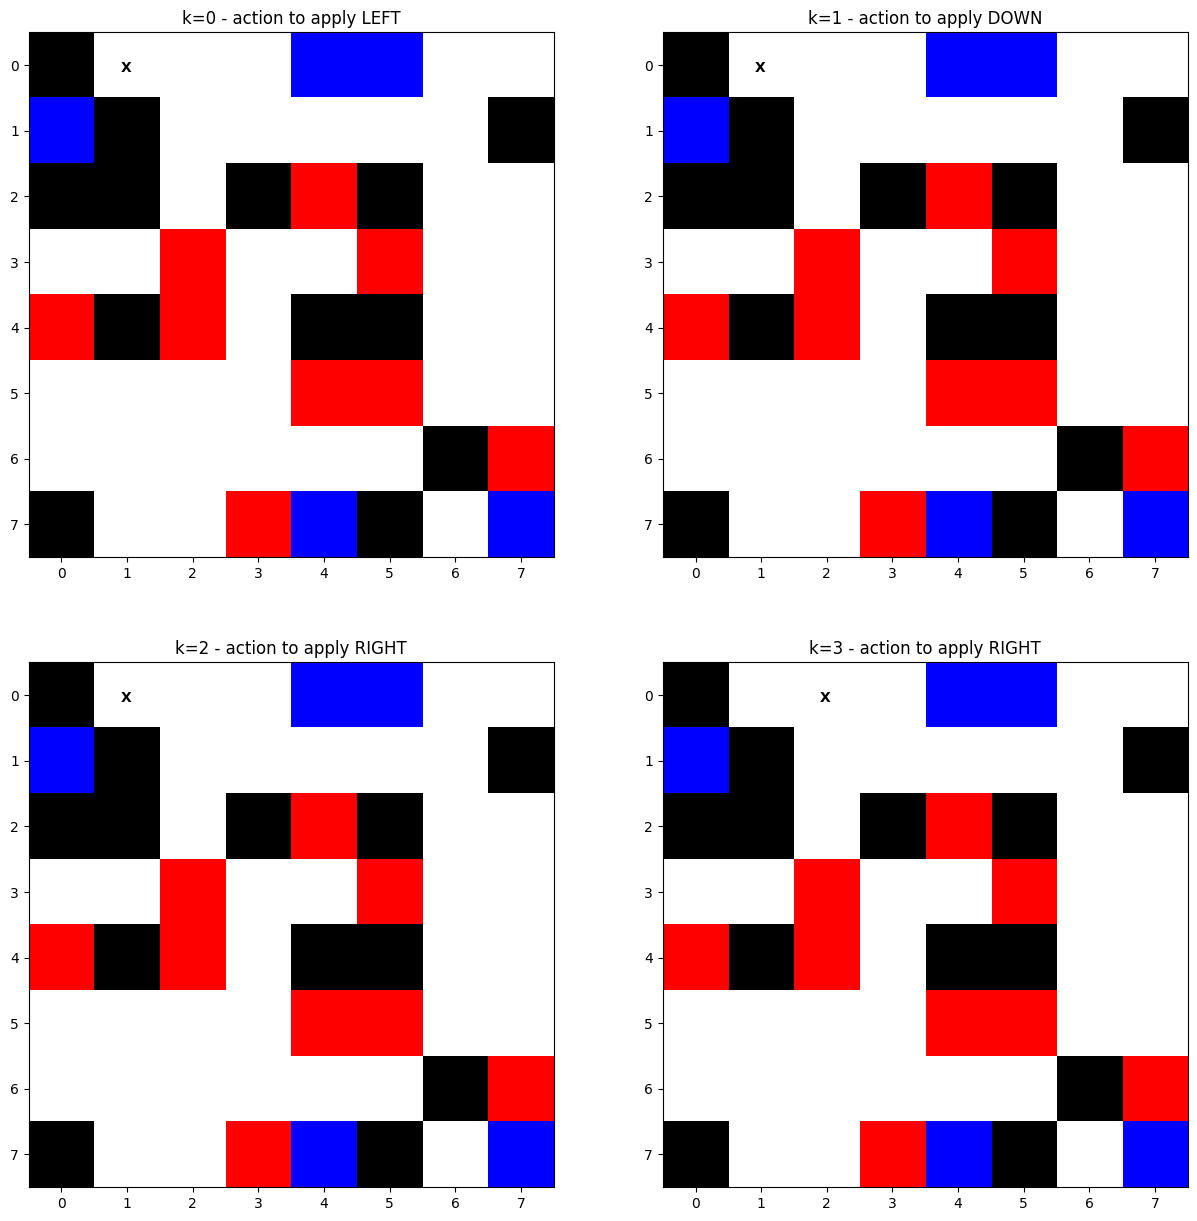

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axes = axes.flatten()
axes
state = (0, 1)
actions = [LEFT, DOWN, RIGHT, RIGHT]
for k, (a, ax) in enumerate(zip(actions, axes)):
    ax.set_title(f"k={k} - action to apply {ACTIONS[a]}")
    draw_board(board, pos=state, ax=ax)
    state, reward, terminal = env(state, a)

## Value Iteration Algorithm

Let us now implement the **asynchronous version** of the **VALUE ITERATION ALGORITHM**. This algorithm will enable us to compute optimal state values for each state.

In [ ]:
def update_state_value(env: MazeEnvironment, s, v, gamma):
    """Update value of the given state.

    Args:
        env (MazeEnvironment): The environment to work on.
        s : The state (cell position).
        v : Values of other states.
        gamma : discount factor.
    """
    rhs = []
    for a in env.get_actions():
        s_new, r, _ = env(s, a)
        rhs.append(r + gamma*v[s_new])
    return max(rhs)

In [ ]:
def async_update_all_values(env: MazeEnvironment, v, gamma):
    """Update values of all states.

    Args:
        env (MazeEnvironment): The environment to work on.
        v : Values of other states.
        gamma : discount factor.
    """
    for s in env.get_states():
        if not env.is_terminal(s):
            v[s] = update_state_value(env, s, v, gamma)
    return copy(v)

In [ ]:
def init_values(env):
    """Randomly initialize states of the given environment."""
    values = {s: -10*random() for s in env.get_states()}

    for s in values:
        if env.is_terminal(s):
            values[s] = 0

    return values

It is also convenient to have a method for visualization of values.

In [ ]:
def draw_values(env, values, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    for s in values:
        ax.text(s[1]-0.25, s[0]+0.1, f"{values[s]:.1f}")

Let us test the above methods by visualizing initial state values, and also the evolution of state values through several initial steps.

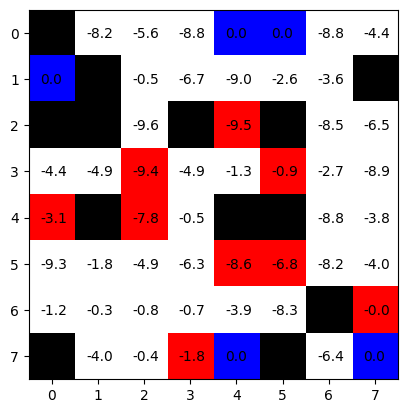

In [ ]:
values = init_values(env)
draw_values(env, values)

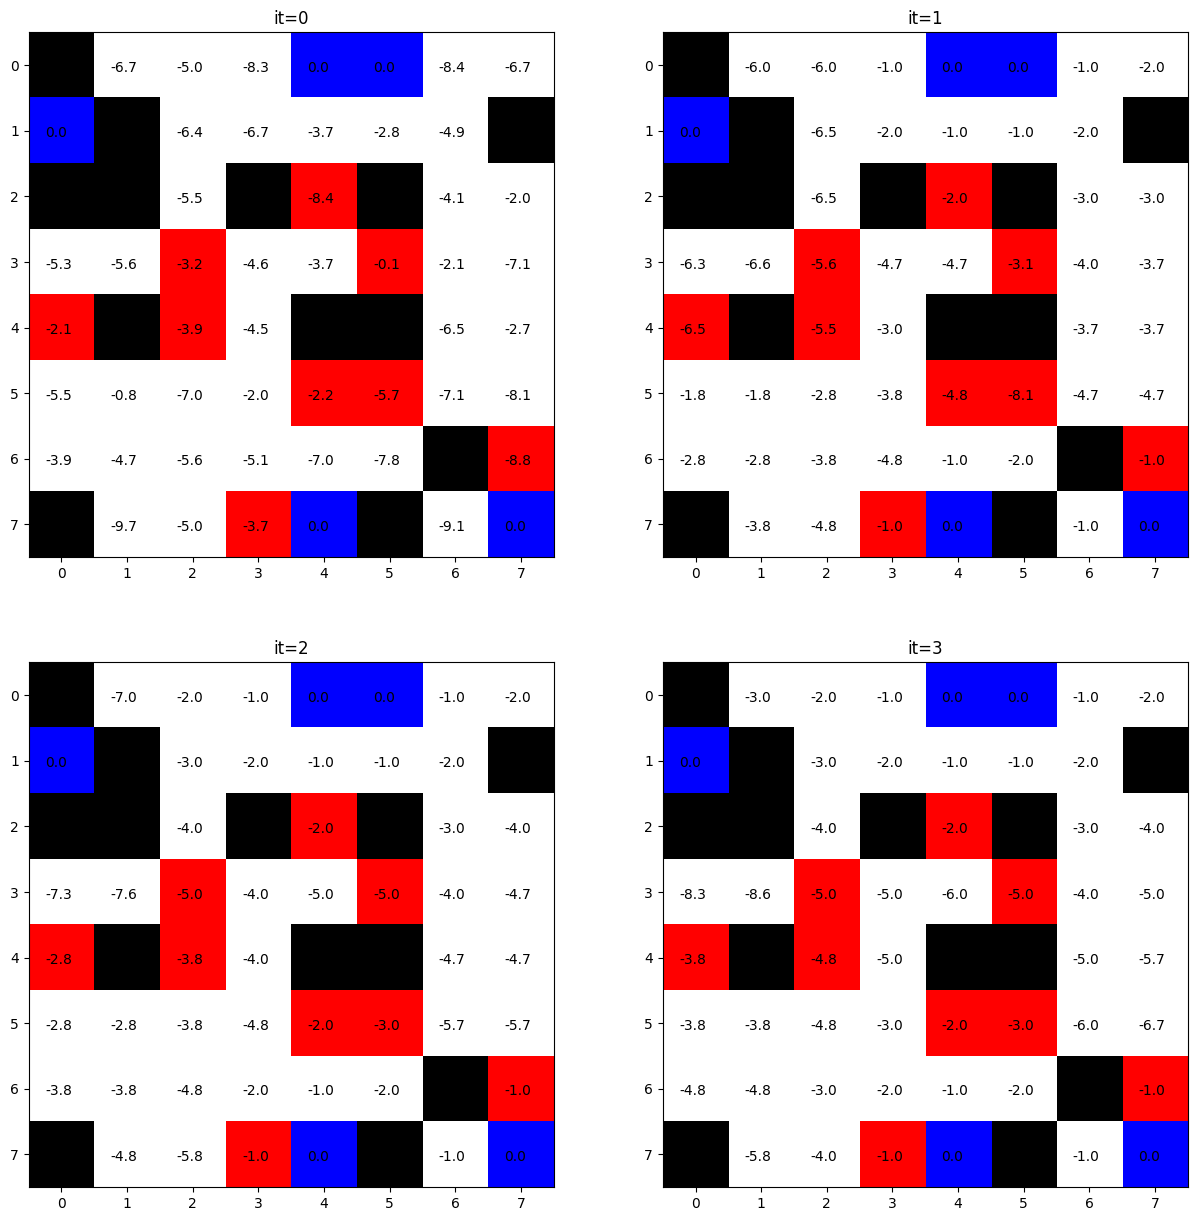

In [ ]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
axes = axes.flatten()
values = init_values(env)
for k in range(nrows*ncols):
    draw_values(env, values, ax)
    axes[k].set_title(f"it={k}")
    draw_values(env, values, ax=axes[k])
    values = async_update_all_values(env, values, 1.0)

We are finally ready to implement the value iteration algorithm.

In [ ]:
def value_iteration(env, gamma, eps, v0=None, maxiter=100):
    v = v0 if v0 is not None else init_values(env)
    for k in range(maxiter):
        nv = async_update_all_values(env, values, gamma)
        err = max([abs(nv[s] - v[s]) for s in v])
        if err<eps:
            return nv, k
        v = nv
    return v, k

Let us test the algorithm by

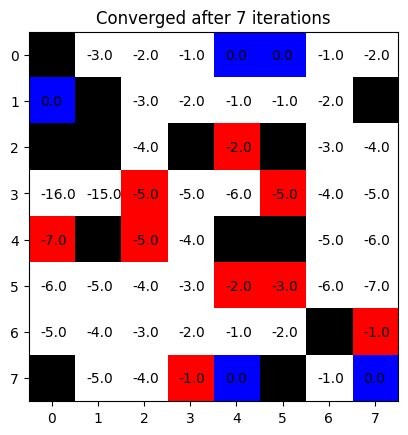

In [ ]:
fin_v, k = value_iteration(env, 1.0, 0.01)
draw_values(env, fin_v)
plt.title(f"Converged after {k} iterations");

## Finding and Visualizing Optimal Decision Policy

Let us first define a function that computes a greedy action (with respect to the given state values) for a specific given state.

In [ ]:
def greedy_action(env, s, v, gamma):
    vs = []
    for a in env.get_actions():
        s_next, r, _ = env(s, a)
        vs.append(r + gamma*v[s_next])
    return np.argmax(vs)

Let us test it to see if we are getting the expected result. Notice that our function will return just a single action, even if there are more than one possibility.

In [ ]:
aopt = greedy_action(env, (5, 4), fin_v, 1.0)
ACTIONS[aopt]

'DOWN'

We can now compute the full optimal policy

In [ ]:
def optimal_policy(env, v, gamma):
    return {s: greedy_action(env, s, v, gamma) for s in env.get_states() if not env.is_terminal(s)}

It is also helpfull to have a function for visualization of policies.

In [ ]:
def action_symbol(a):
    if a == RIGHT:
        return "→"
    elif a==UP:
        return "↑"
    elif a==LEFT:
        return "←"
    elif a == DOWN:
        return "↓"
    else:
        raise "Unknown action"

def draw_policy(env, policy, ax=None):
    ax = ax if ax is not None else plt
    draw_board(env.board, ax=ax)
    for s, a in policy.items():
        ax.text(s[1]-0.25, s[0]+0.1, action_symbol(a))

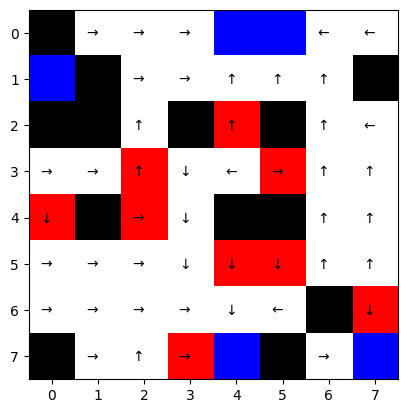

In [ ]:
pi = optimal_policy(env, fin_v, 1.0)
draw_policy(env, pi)

## Assignments for Individual Work (Level 1)

1. Add TELEPORT CELLS and modify the code to accomodate this kind of cells also.
2. Implement value iteration algorithm using Q function instead of V function.
3. Implement policy iteration algorithm using both V and Q functions.

In all cases update, modify, and add visualization facilities to illustrate correctness of the implementation.

## Assignments for Individual Work (Level 2)

1. Modify the code assuming that the maze is stochastic (so that a given action in a given cell may result with different outcomes with different known probabilities)
2. Repeat Level 1 assignments for this kind of maze.

## Assignments for Individual Work (Level 3)

1. Repeat Level 1 assignments assuming that the Maze is graph-like and not grid-like, so that there are different possible actions to take from each cell.